In [43]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import torch
from transformers import AutoTokenizer, EsmModel

### Download the pretrained weights: SeqDance_35M_update_200000.tar from [![DOI](https://zenodo.org/badge/DOI/10.5281/zenodo.13909695.svg)](https://doi.org/10.5281/zenodo.13909695)

In [44]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

checkpoint_path = '/your_path_to/SeqDance_35M_update_200000.tar'
checkpoint = torch.load(checkpoint_path, map_location=device)

### SeqDance is trained using the architecture of ESM2 (35M), replacing ESM2 (35M) with SeqDance weights
We need to select weights with "esm2" in the name

In [45]:
new_checkpoint = {}
for k in checkpoint:
    if 'esm2' in k:
        new_checkpoint[k[5:]] = checkpoint[k]

In [46]:
model_id = "facebook/esm2_t12_35M_UR50D"
tokenizer = AutoTokenizer.from_pretrained(model_id)
seqdance = EsmModel.from_pretrained(model_id)

seqdance.load_state_dict(new_checkpoint, strict=False)
seqdance = seqdance.to(device)
seqdance.eval()

Some weights of EsmModel were not initialized from the model checkpoint at facebook/esm2_t12_35M_UR50D and are newly initialized: ['esm.pooler.dense.bias', 'esm.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


EsmModel(
  (embeddings): EsmEmbeddings(
    (word_embeddings): Embedding(33, 480, padding_idx=1)
    (dropout): Dropout(p=0.0, inplace=False)
    (position_embeddings): Embedding(1026, 480, padding_idx=1)
  )
  (encoder): EsmEncoder(
    (layer): ModuleList(
      (0-11): 12 x EsmLayer(
        (attention): EsmAttention(
          (self): EsmSelfAttention(
            (query): Linear(in_features=480, out_features=480, bias=True)
            (key): Linear(in_features=480, out_features=480, bias=True)
            (value): Linear(in_features=480, out_features=480, bias=True)
            (dropout): Dropout(p=0.0, inplace=False)
            (rotary_embeddings): RotaryEmbedding()
          )
          (output): EsmSelfOutput(
            (dense): Linear(in_features=480, out_features=480, bias=True)
            (dropout): Dropout(p=0.0, inplace=False)
          )
          (LayerNorm): LayerNorm((480,), eps=1e-05, elementwise_affine=True)
        )
        (intermediate): EsmIntermediate(
  

### Get the SeqDance embedding for a protein ([TP53](https://www.uniprot.org/uniprotkb/P04637/entry) here)

In [47]:
TP53 = 'MEEPQSDPSVEPPLSQETFSDLWKLLPENNVLSPLPSQAMDDLMLSPDDIEQWFTEDPGPDEAPRMPEAAPPVAPAPAAPTPAAPAPAPSWPLSSSVPSQKTYQGSYGFRLGFLHSGTAKSVTCTYSPALNKMFCQLAKTCPVQLWVDSTPPPGTRVRAMAIYKQSQHMTEVVRRCPHHERCSDSDGLAPPQHLIRVEGNLRVEYLDDRNTFRHSVVVPYEPPEVGSDCTTIHYNYMCNSSCMGGMNRRPILTIITLEDSSGNLLGRNSFEVRVCACPGRDRRTEEENLRKKGEPHHELPPGSTKRALPNNTSSSPQPKKKPLDGEYFTLQIRGRERFEMFRELNEALELKDAQAGKEPGGSRAHSSHLKSKKGQSTSRHKKLMFKTEGPDSD'

raw_input = tokenizer([TP53], return_tensors="pt") # Note: the tokenizer add <cls> and <eos> to the start and end of the sequence
raw_input = raw_input.to(device)

In [48]:
with torch.no_grad():
    output = seqdance(raw_input['input_ids'], output_attentions = True)

In [49]:
# the last hidden state can be used for per-residue tasks, you can also take the average for protein level tasks
output['last_hidden_state']

tensor([[[ 0.1350, -0.0322, -0.0151,  ..., -0.3009,  0.1010,  0.0793],
         [ 0.2324,  0.0189, -0.2978,  ..., -0.1445,  0.0525, -0.2160],
         [ 0.2280, -0.0065, -0.2533,  ..., -0.1826,  0.0140, -0.1618],
         ...,
         [ 0.0723,  0.0677, -0.2827,  ..., -0.2223,  0.0116, -0.1370],
         [ 0.0507,  0.0425, -0.3469,  ..., -0.1846,  0.0419, -0.0897],
         [ 0.1454, -0.0456, -0.0378,  ..., -0.3074,  0.0852,  0.1197]]])

### Select the top10 heads for predicting interaction and co-movement
If you are interested in the dynamic feature prediction heads, you can look into "res_pred_linear.weight", "res_pred_linear.bias", "pair_median_linear_1.weight", "pair_median_linear_1.bias", "pair_median_linear_2.weight", "pair_median_linear_2.bias", "pair_pred_linear.weight", "pair_pred_linear.bias". For detailed description of these layers, you can refer to the code of the model.

In [50]:
w_pair = checkpoint['pair_pred_linear.weight'].cpu().numpy()

w_att_inter = w_pair[:9, -240:] # the weight for attention maps to predict interaction map

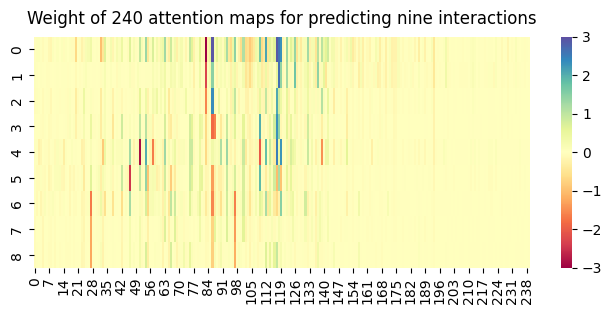

In [51]:
plt.figure(figsize=[8,3])
sns.heatmap(w_att_inter, cmap="Spectral", center=0, vmax=3, vmin=-3)
plt.title('Weight of 240 attention maps for predicting nine interactions', y = 1.02)
plt.show()

### Visualize pairwise features-related attention maps

In [52]:
# Get the top 10 heads for nine interactions
w_att_inter_sum = w_att_inter.sum(axis = 0)
top10_inter_att = np.argsort(w_att_inter_sum, )[-10:][::-1]

# Get the top 10 heads for co-movement
top10_move_att = np.argsort(w_pair[9, -240:])[-10:][::-1]

In [53]:
attention = torch.cat(output['attentions'], dim=1).permute(0, 2, 3, 1).squeeze_() # combine attentions in 12 layers
attention = attention.cpu().numpy()[1:-1,1:-1,:] # remove attentions for <cls> and <eos>

attention_inter = attention[:,:,top10_inter_att].mean(axis=-1) # mean of the top10 important heads

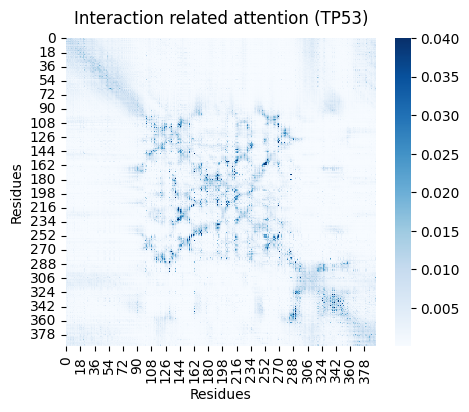

In [54]:
# visulize the interaction related attention map
plt.figure(figsize=[5,4])
sns.heatmap(attention_inter, cmap='Blues', vmax=0.04)
plt.xlabel('Residues')
plt.ylabel('Residues')
plt.title('Interaction related attention (TP53)', y = 1.02)
plt.show()